# Initial Exploration

## Problem description

Let f(x, P) be a neural network with fixed structure that takes as input a feature vector x and computes a real-valued output based on learnable parameters P.  Suppose that in response to a training example, the parameters are updated to P'.  The difference between the value of the function before and after the update is:

f(x, P) - f(x, P')

We would like a network that generalizes in the neighborhood of x.  That is, if x' is an input vector “close” to x, we would like the change in f due to the change in P at x to be similar in sign and magnitude to the change in f at x' due to the change in P.  The latter quantity can be written:

f(x', P) - f(x', P')

They are similar if the following loss is _all:

L\_gen = ((f(x, P) - f(x, P')) - (f(x', P) - f(x', P'))^2

If I update the parameters from P to P', the change in f should be similar in the neighborhood of x.  As |x - x'| gets larger, the neighborhood of the generalization increases.

Our goal is to pre-train a network using unlabeled data to get into a part of the parameter space such that generalization during pre-training is broad, thereby leading to faster convergence.  Consider the following algorithmic approach to this idea.


```
Input: X = {x1, x2, , xn}, neural network f, x, P
x is the standard deviation of the noise applied to x
p is the standard deviation of the noise applied to P

While not converged
  Choose x from X at random
  x’ = x + N(0, x)
  P’ = P + N(0, P)
  Compute derivative of  Lgen wrt P
  Update P using gradient descent

Return P
```gradient descent

Return P


In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import MNIST

In [2]:
class TinyModel(nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(1, 10),
            nn.ELU(),
            nn.Linear(10, 30),
            nn.ELU(),
            nn.Linear(30, 10),
            nn.ELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
class FunctionDataset(Dataset):
    
    def __init__(self, function, num_samples, start=0, stop=2*math.pi, jitter=0, rand_pts=False):
        self.num_samples = num_samples
        self.start = start
        self.stop = start
        self.jitter = jitter

        if not rand_pts:
            pts = np.linspace(start, stop, num_samples)
            self.data = torch.from_numpy(pts).to(torch.float32)
        else:
            self.data = torch.zeros((num_samples,), dtype=torch.float32).uniform_(start, stop)
        self.labels = function(self.data).to(torch.float32)
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        label = self.labels[idx]
        if self.jitter != 0:
            label = label +  torch.normal(0, self.jitter, label.shape)
        return self.data[idx], label

    def get_data(self):
        return self.data

    def get_labels(self):
        return self.labels
        

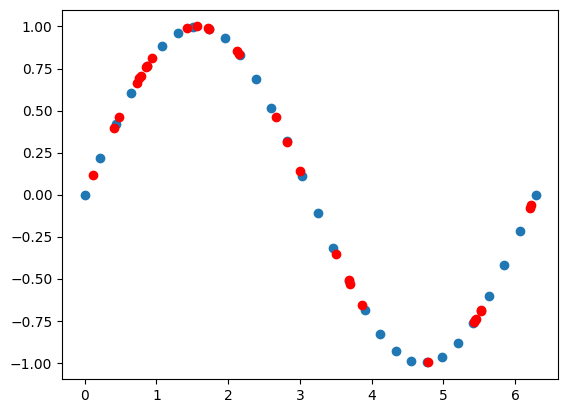

In [4]:
train_data = FunctionDataset(torch.sin, 30, stop=2*math.pi)
test_data = FunctionDataset(torch.sin, 30, stop=2*math.pi, rand_pts=True)
plt.scatter(train_data.get_data().numpy(), train_data.get_labels().numpy())
plt.scatter(test_data.get_data().numpy(), test_data.get_labels().numpy(), color='red')

train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [5]:
learning_rate = 1e-2
epochs = 140

# all models should have the same initial weights
sin_model = TinyModel()
precond_model = copy.deepcopy(sin_model)
jittered_model = copy.deepcopy(sin_model)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(sin_model.parameters(), lr=learning_rate)

In [6]:
# Taken from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html and somewhat altered
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0
    batches = 0
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        batches += 1
        
    return total_loss / batches

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    xs = []
    ys = []
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            xs.append(X.item())
            preds.append(pred.item())
            ys.append(y.item())
            test_loss += loss_fn(pred, y).item()

    plt.scatter(xs, ys, label="True points")
    plt.scatter(xs, preds, label="Predictions")
    plt.legend()

    plt.show()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

In [7]:
# Based off Mohammad M's initial code sample
def nbd_loss(a, b, c, d):
    return torch.sum(((a-b) - (c-d))**2)

def precond_loop(network, network_prime, dataloader, four_loss, optimizer, std=.05):
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):

        optimizer.zero_grad()
        x_prime = X + torch.normal(0, std, X.shape)
        
        param_prime = {}
        for name, p in network.state_dict().items():
            param_prime[name] = p.clone() + torch.normal(0, std, p.shape)
            param_prime[name].requires_grad = False
        network_prime.load_state_dict(param_prime)

        # forward 1: f(x, p)
        y_x_p = network(X)
        # forward 2: f(x', p)
        y_xp_p = network(x_prime)
        # forward 3: f(x, p')
        y_x_pp = network_prime(X)
        # forward 4: f(x', p')
        y_xp_pp = network_prime(x_prime)
        
        loss = four_loss(y_x_p, y_x_pp, y_xp_p, y_xp_pp)
        
        # backward: calculating the gradients w.r.t. p. Gradients of p' is turned off in line 44
        loss.backward()
        # update weights
        optimizer.step()
        total_loss += loss.item()
    return total_loss / batch

def model_residual_F(model_a: torch.nn.Module, model_b: torch.nn.Module):
    # assumes model_a and model_b have the same shape & weights
    with torch.no_grad():
        a_dict = model_a.state_dict()
        
        b_dict = model_b.state_dict() if model_b is not None else None
        total = 0
        for param_name in a_dict.keys():
            if b_dict is not None:
                partial_resid = a_dict[param_name] - b_dict[param_name]
                partial_resid = partial_resid ** 2
            else:
                partial_resid = a_dict[param_name] ** 2
            total += torch.sum(partial_resid).item()
    
        return total ** 0.5

Epoch: 1


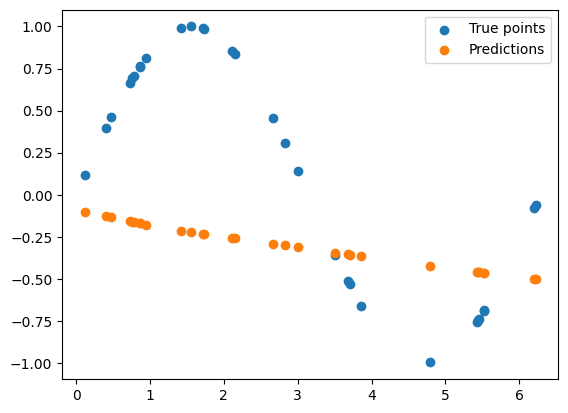

Avg loss: 0.541172 

Epoch: 2


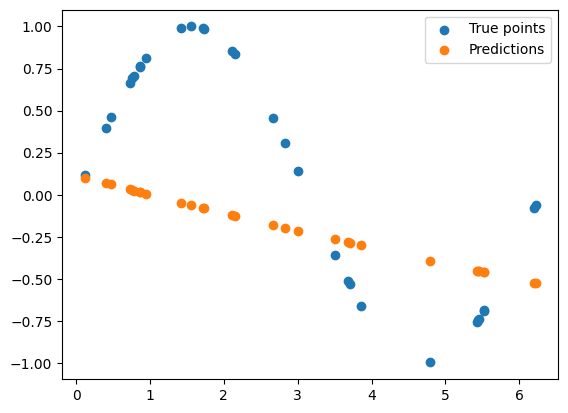

Avg loss: 0.395564 

Epoch: 3


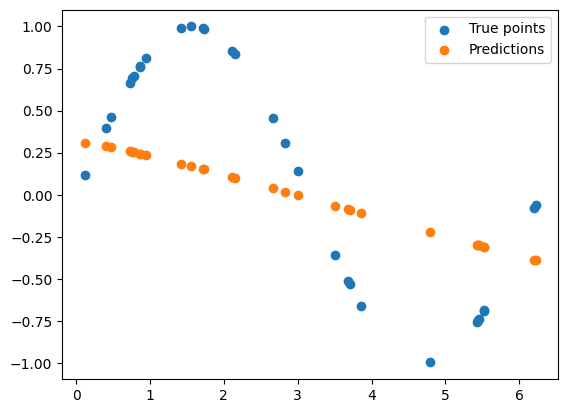

Avg loss: 0.269416 

Epoch: 4


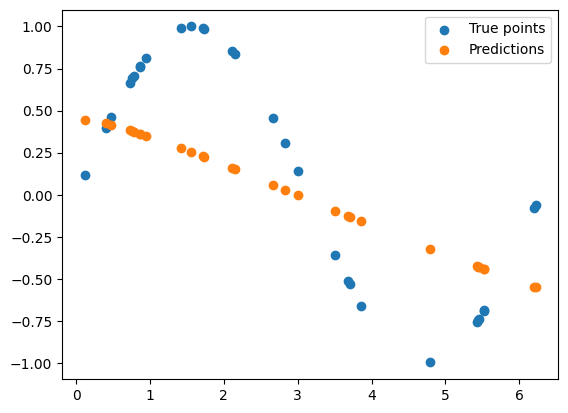

Avg loss: 0.211566 

Epoch: 5


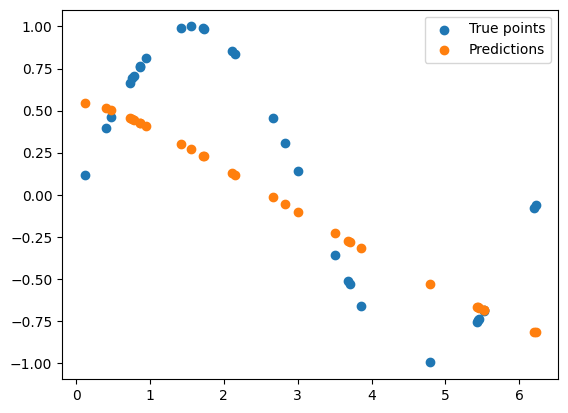

Avg loss: 0.198865 

Epoch: 6


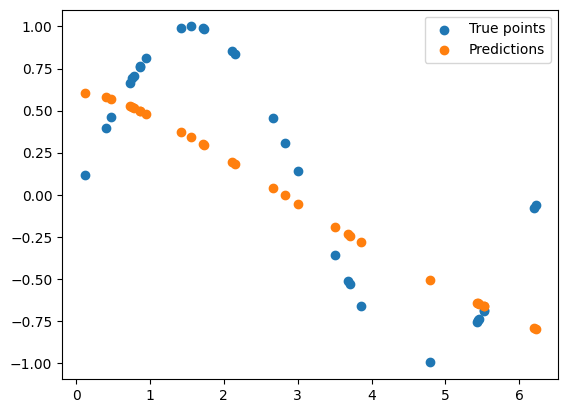

Avg loss: 0.173400 

Epoch: 7


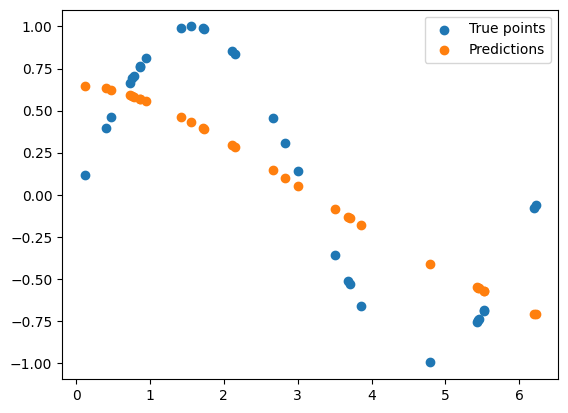

Avg loss: 0.150219 

Epoch: 8


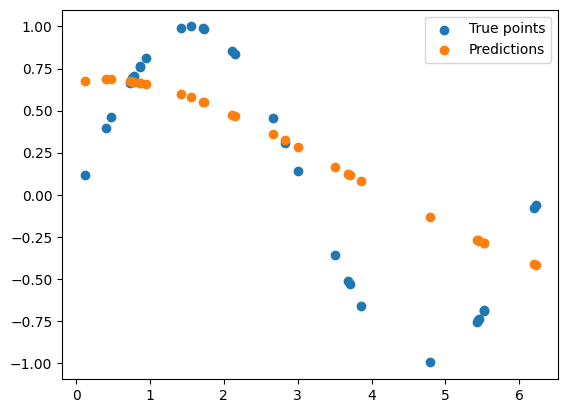

Avg loss: 0.171402 

Epoch: 9


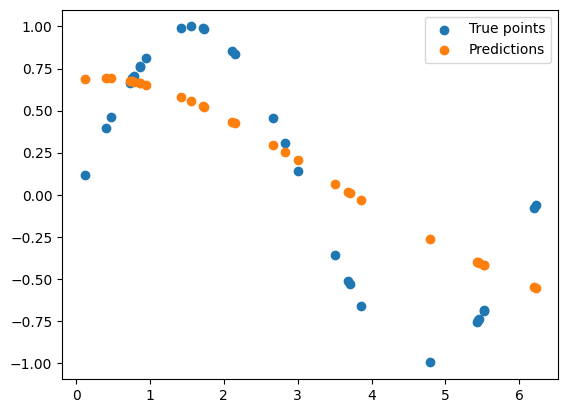

Avg loss: 0.144903 

Epoch: 10


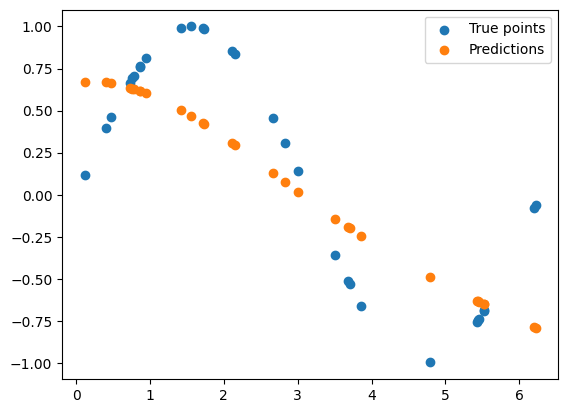

Avg loss: 0.140467 

Epoch: 11


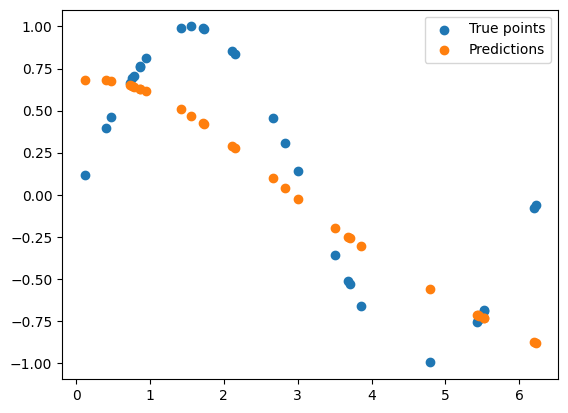

Avg loss: 0.144580 

Epoch: 12


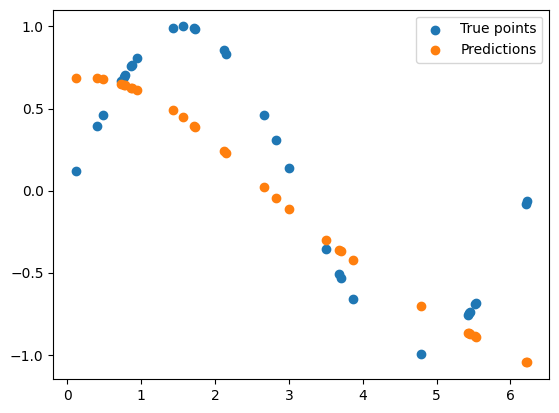

Avg loss: 0.171540 

Epoch: 13


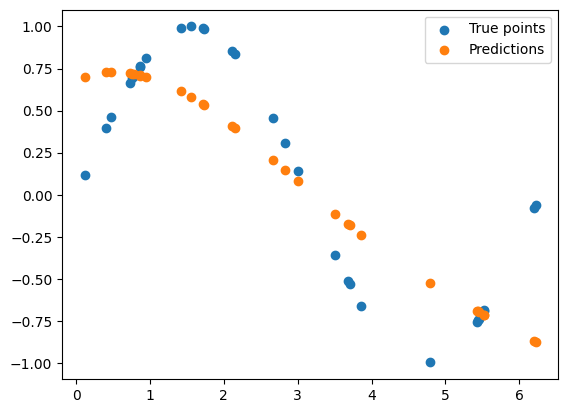

Avg loss: 0.125302 

Epoch: 14


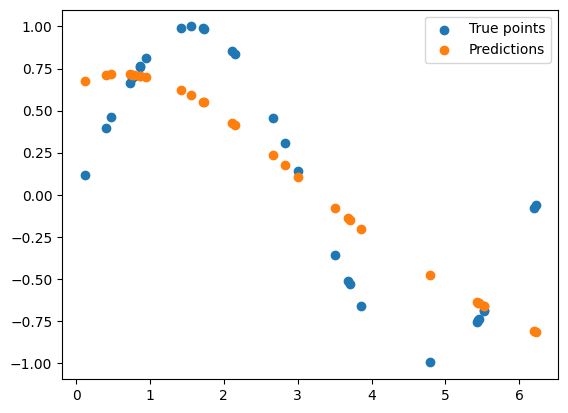

Avg loss: 0.119372 

Epoch: 15


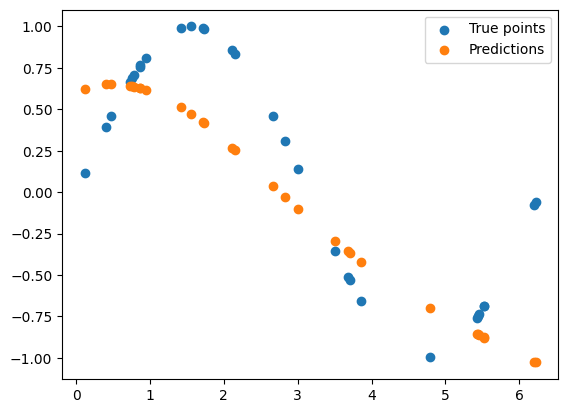

Avg loss: 0.159368 

Epoch: 28


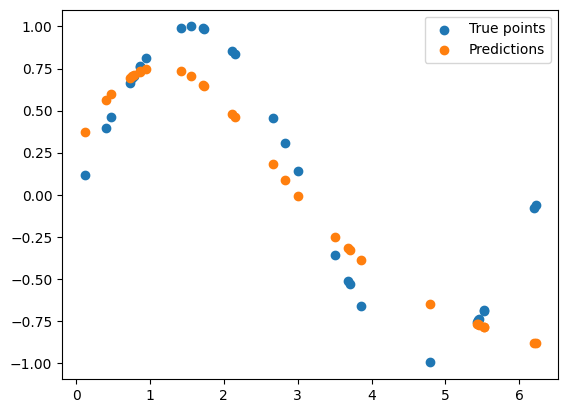

Avg loss: 0.084865 

Epoch: 56


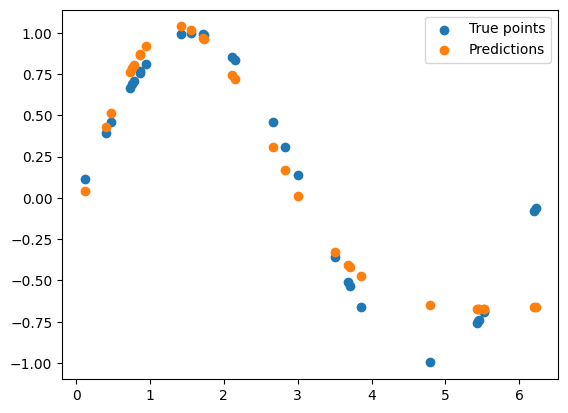

Avg loss: 0.035203 

Epoch: 84


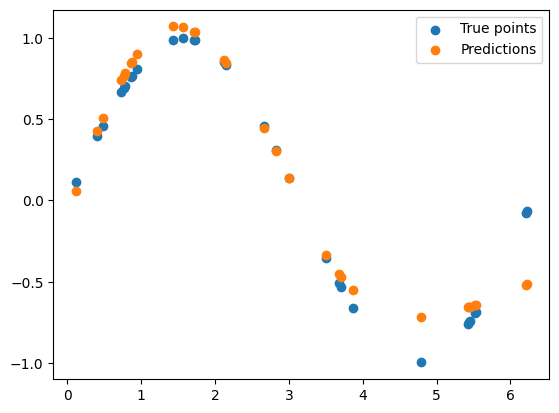

Avg loss: 0.019628 

Epoch: 112


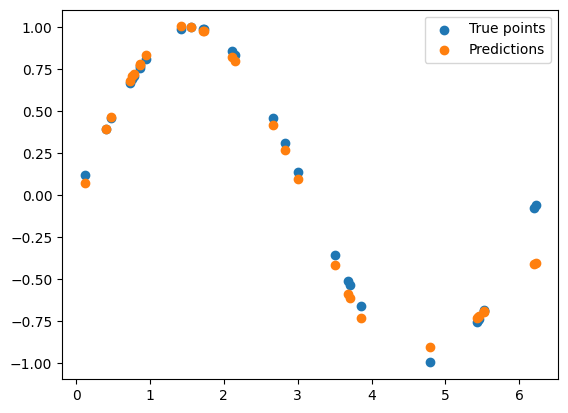

Avg loss: 0.009111 

Epoch: 140


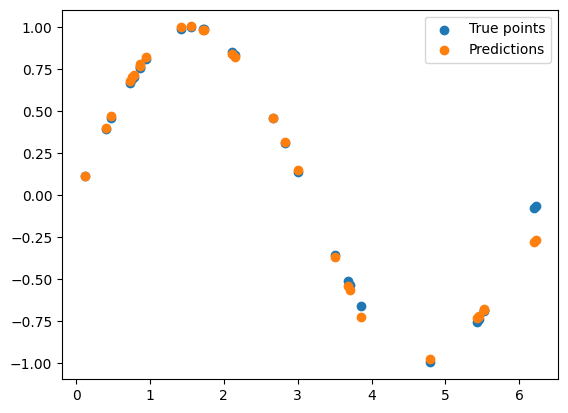

Avg loss: 0.003080 

Done!


In [8]:
standard_train_losses = []

for t in range(epochs):
    
    standard_train_losses.append(train_loop(train_dataloader, sin_model, loss_function, optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, sin_model, loss_function)
print("Done!")

In [9]:
# Pretraining:
precond_epochs = 200
precond_prime = TinyModel()

precond_lr = 1e-3
precond_optimizer = torch.optim.SGD(precond_model.parameters(), lr=precond_lr)


precond_losses = []
precond_training_losses = []

Epoch: 1


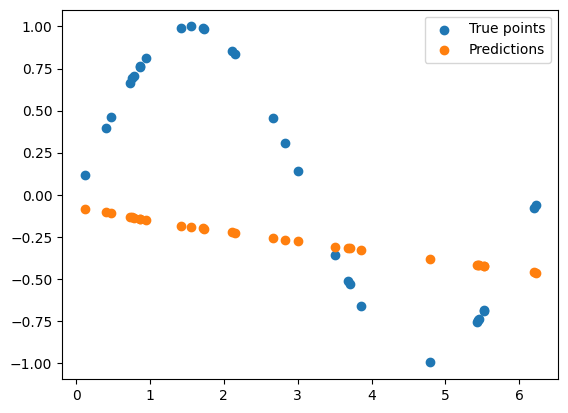

Avg loss: 0.515826 

Epoch: 2


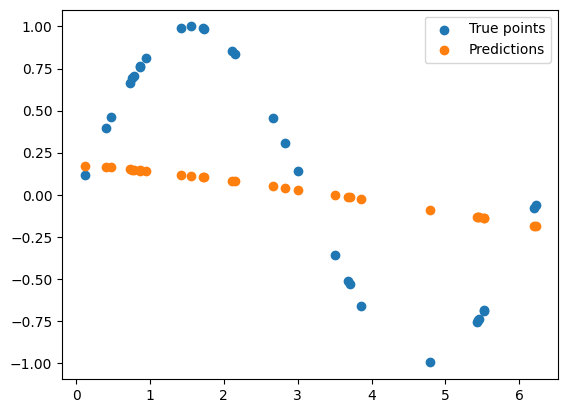

Avg loss: 0.345954 

Epoch: 3


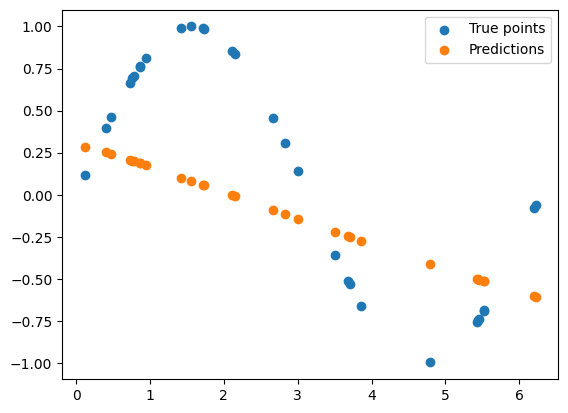

Avg loss: 0.290546 

Epoch: 4


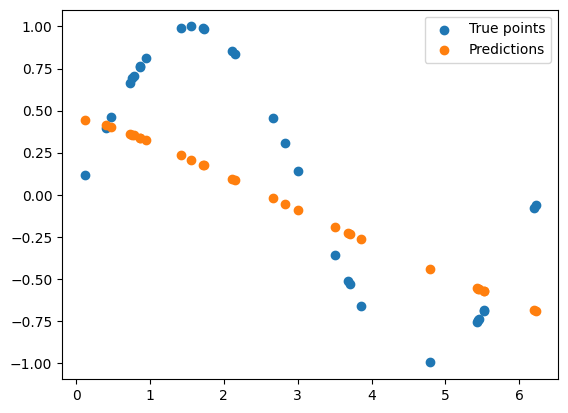

Avg loss: 0.221930 

Epoch: 5


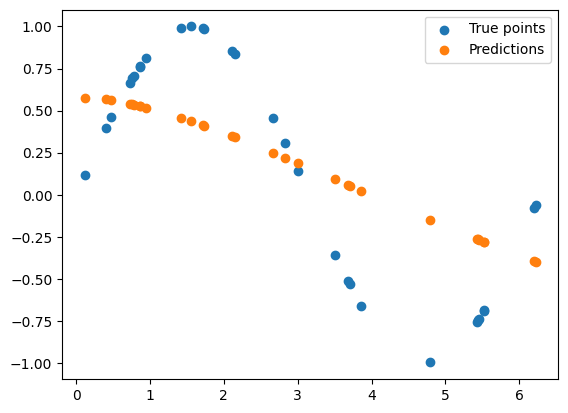

Avg loss: 0.188068 

Epoch: 6


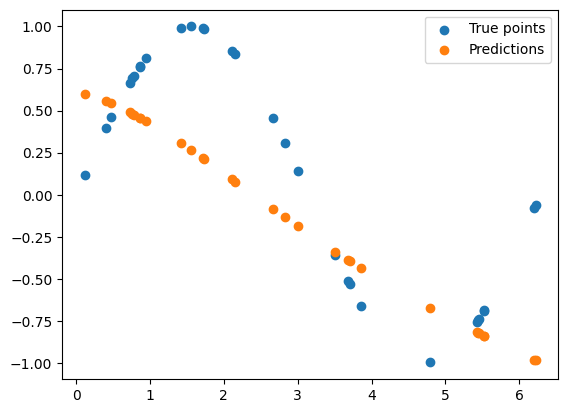

Avg loss: 0.219625 

Epoch: 7


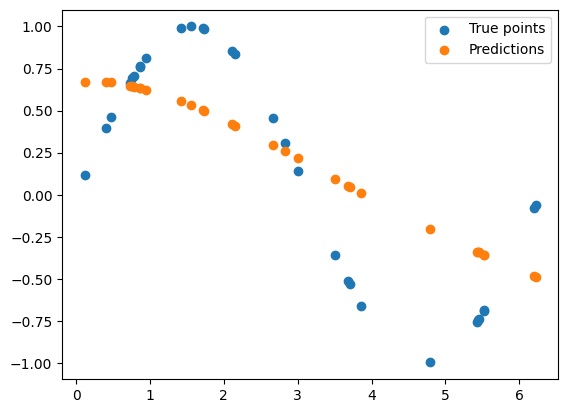

Avg loss: 0.159576 

Epoch: 8


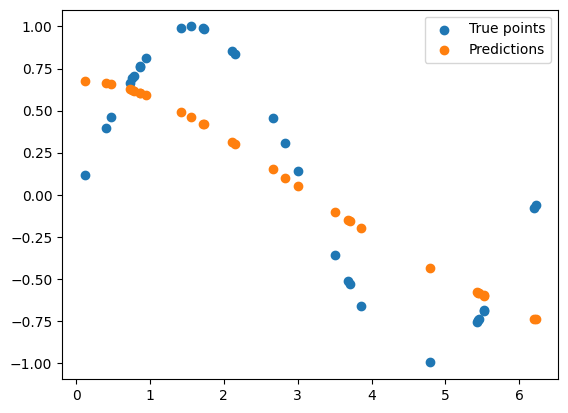

Avg loss: 0.143367 

Epoch: 9


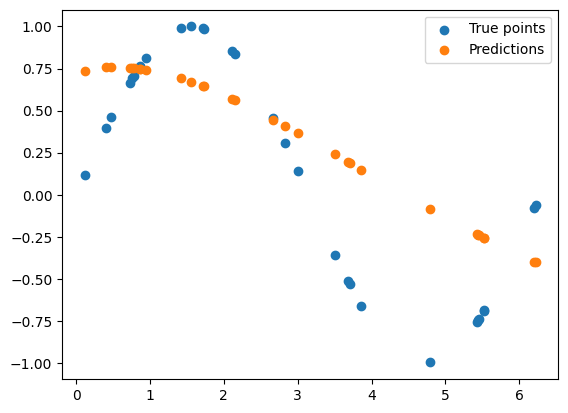

Avg loss: 0.183673 

Epoch: 10


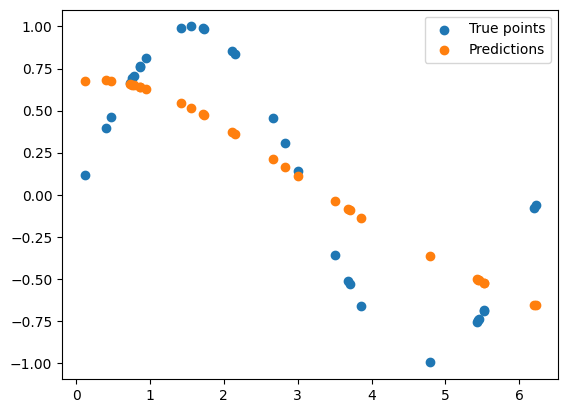

Avg loss: 0.135369 

Epoch: 11


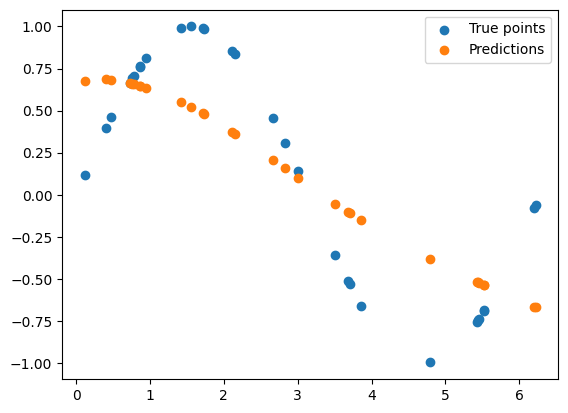

Avg loss: 0.132210 

Epoch: 12


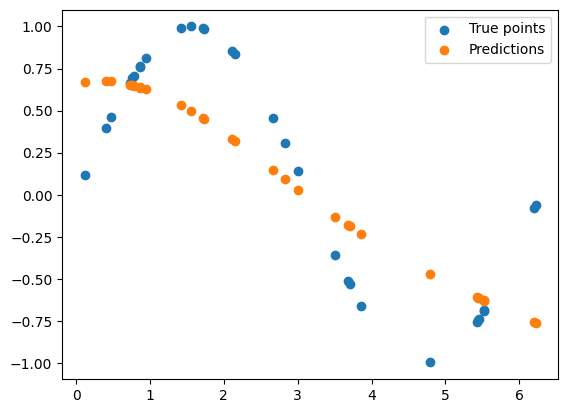

Avg loss: 0.132849 

Epoch: 13


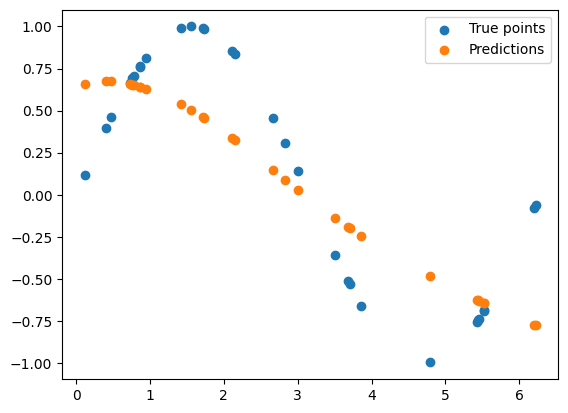

Avg loss: 0.130357 

Epoch: 14


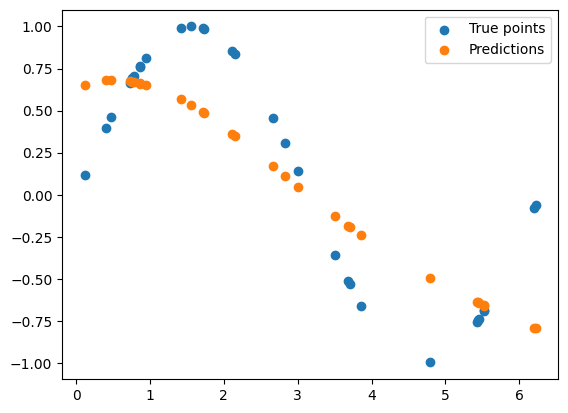

Avg loss: 0.125013 

Epoch: 15


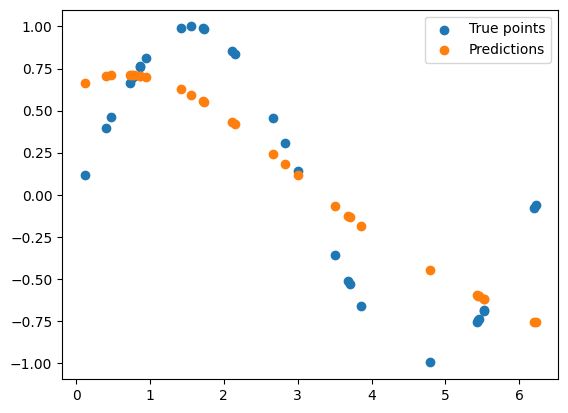

Avg loss: 0.116952 

Epoch: 28


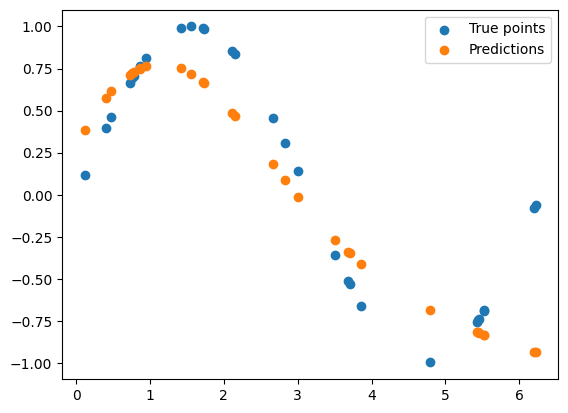

Avg loss: 0.089528 

Epoch: 56


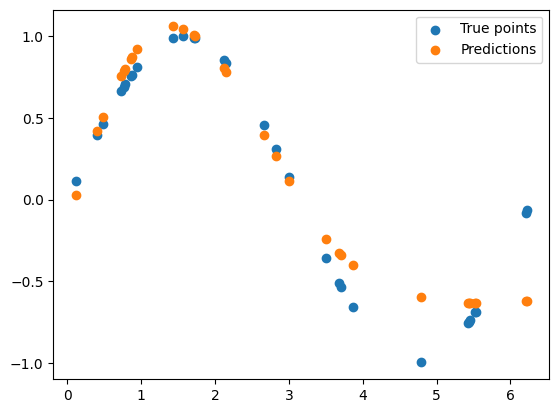

Avg loss: 0.035221 

Epoch: 84


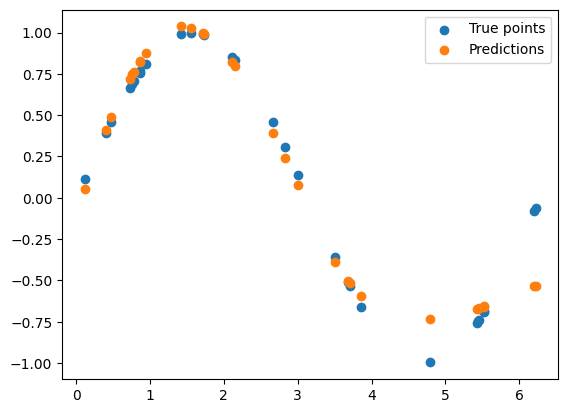

Avg loss: 0.018994 

Epoch: 112


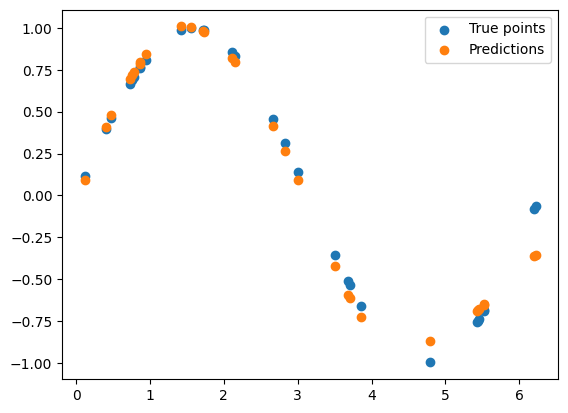

Avg loss: 0.007872 

Epoch: 140


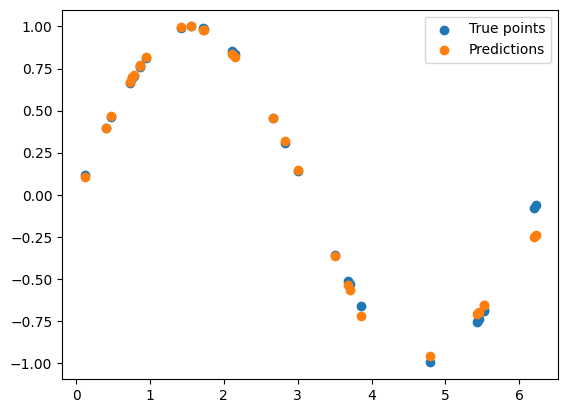

Avg loss: 0.002616 

Done!


In [10]:
original_model = copy.deepcopy(precond_model)

for t in range(precond_epochs):
    precond_losses.append(precond_loop(precond_model, precond_prime, train_dataloader, nbd_loss, precond_optimizer))
    
residual = model_residual_F(precond_model, original_model)

# we will use the same preconditioning to train a model for cosine
cos_precond_model = copy.deepcopy(precond_model)

training_optimizer = torch.optim.SGD(precond_model.parameters(), lr=learning_rate)
for t in range(epochs):
    
    precond_training_losses.append(train_loop(train_dataloader, precond_model, loss_function, training_optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, precond_model, loss_function)
print("Done!")

In [11]:
print(f"Norm of untrained model:", model_residual_F(original_model, None))
print(f"Norm of trained standard model:", model_residual_F(sin_model, None))
print(f"Norm of trained preconditioned model:", model_residual_F(precond_model, None))
print(f"Residual from preconditioning:", residual)
print(f"Residual between trained models:", model_residual_F(precond_model, sin_model))

Norm of untrained model: 4.8009592825234595
Norm of trained standard model: 5.583976392683559
Norm of trained preconditioned model: 5.58409207327925
Residual from preconditioning: 9.692692709603692e-06
Residual between trained models: 0.02738551211111713


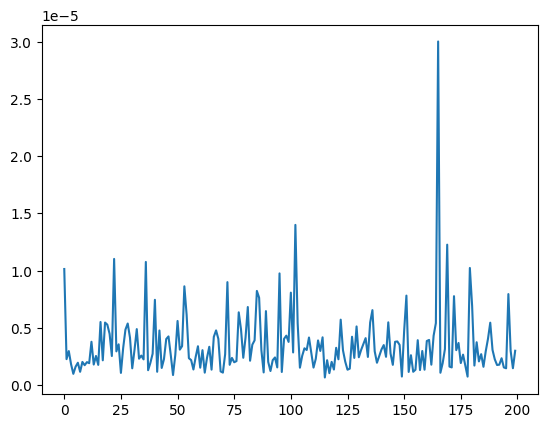

In [12]:
plt.plot(list(range(precond_epochs)), precond_losses)

Epoch: 1


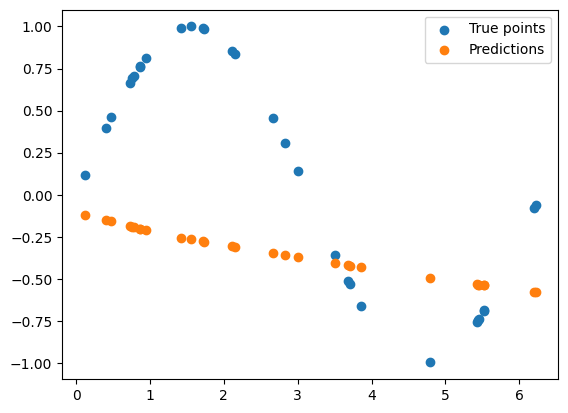

Avg loss: 0.578328 

Epoch: 2


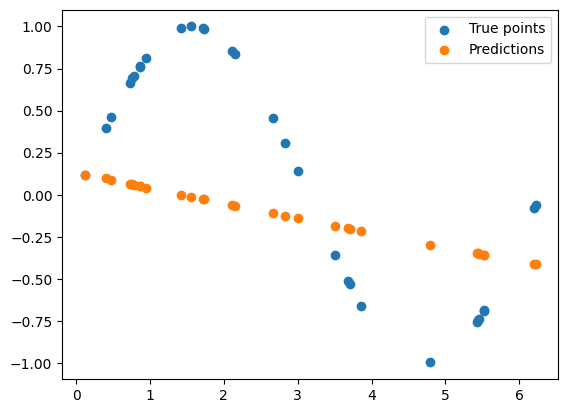

Avg loss: 0.372174 

Epoch: 3


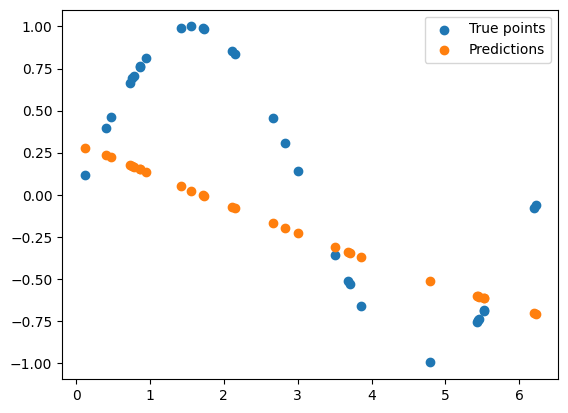

Avg loss: 0.322300 

Epoch: 4


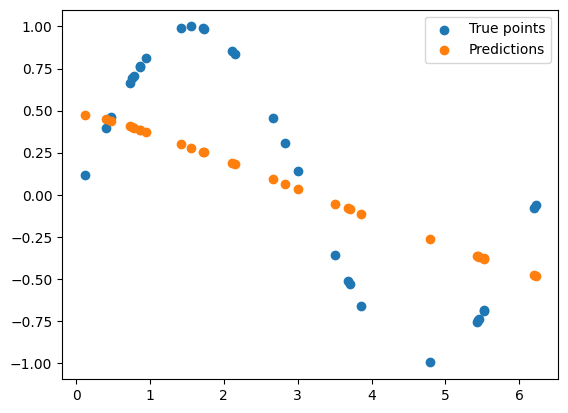

Avg loss: 0.209054 

Epoch: 5


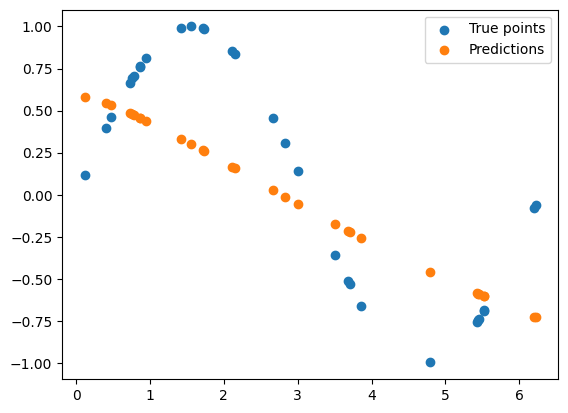

Avg loss: 0.184639 

Epoch: 6


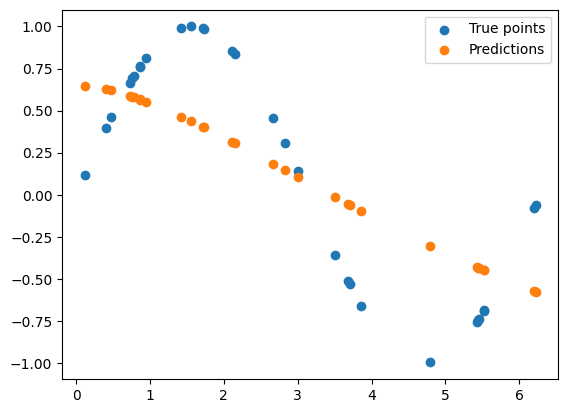

Avg loss: 0.158255 

Epoch: 7


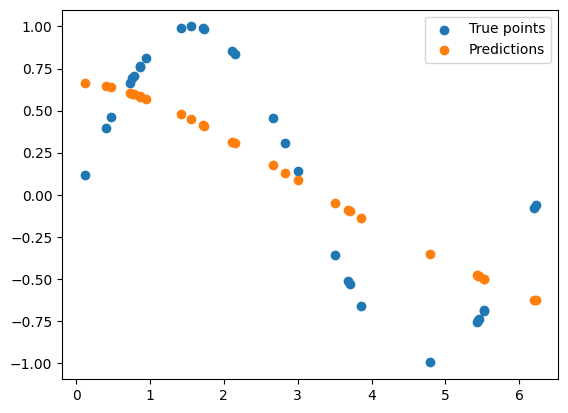

Avg loss: 0.150276 

Epoch: 8


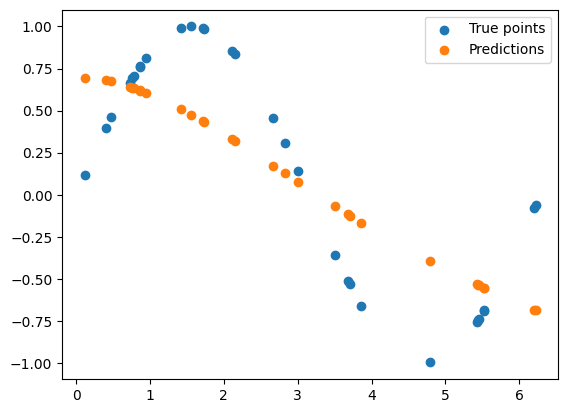

Avg loss: 0.142692 

Epoch: 9


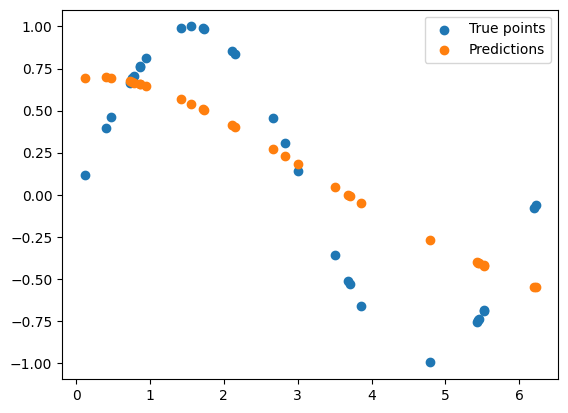

Avg loss: 0.144994 

Epoch: 10


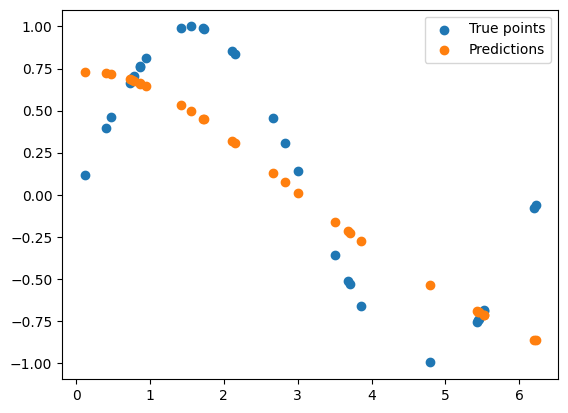

Avg loss: 0.140982 

Epoch: 11


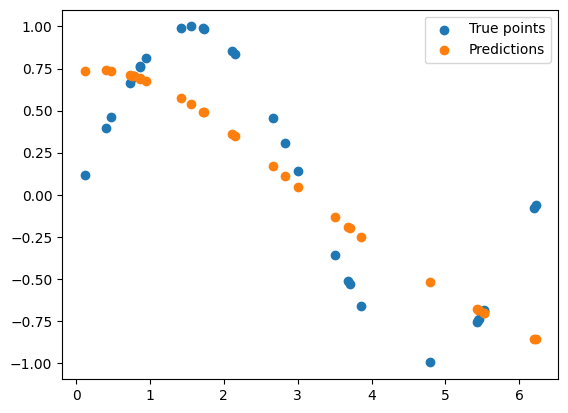

Avg loss: 0.133574 

Epoch: 12


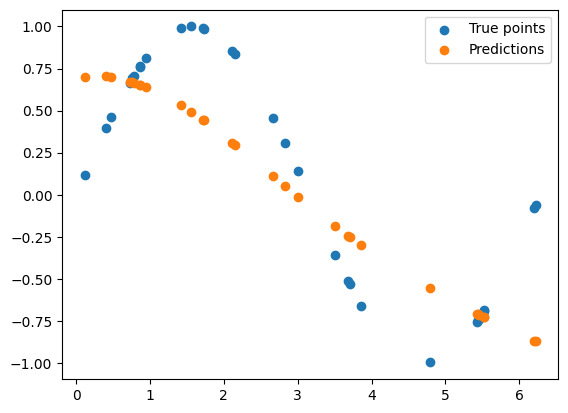

Avg loss: 0.139727 

Epoch: 13


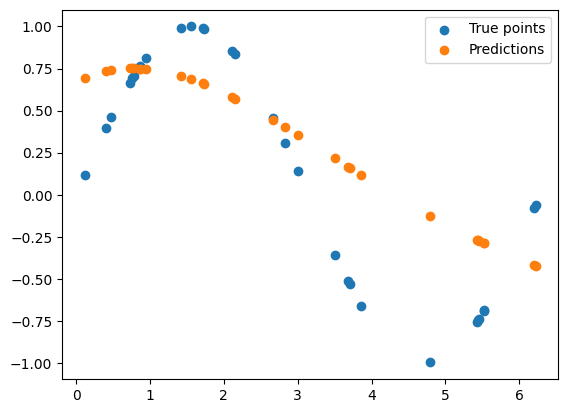

Avg loss: 0.166702 

Epoch: 14


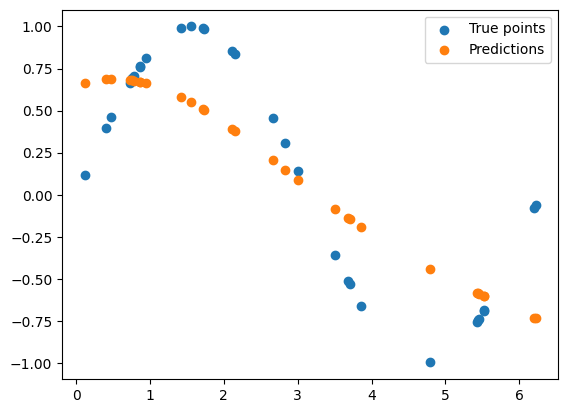

Avg loss: 0.122886 

Epoch: 15


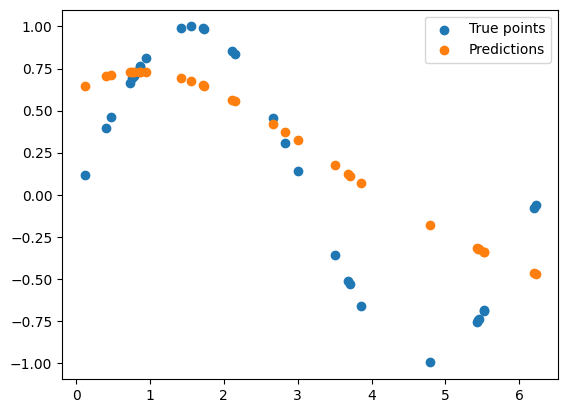

Avg loss: 0.149512 

Epoch: 28


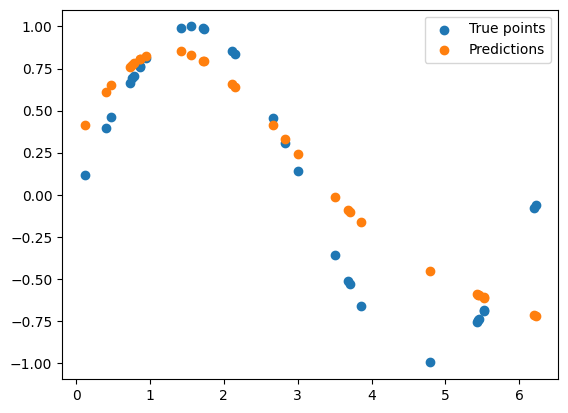

Avg loss: 0.078117 

Epoch: 56


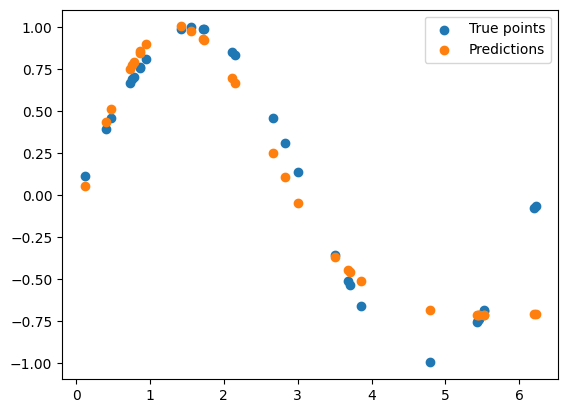

Avg loss: 0.039534 

Epoch: 84


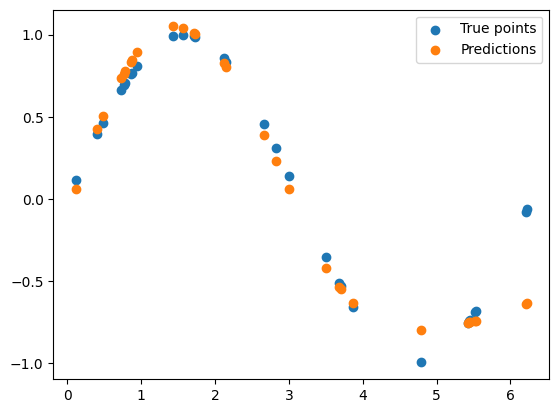

Avg loss: 0.025274 

Epoch: 112


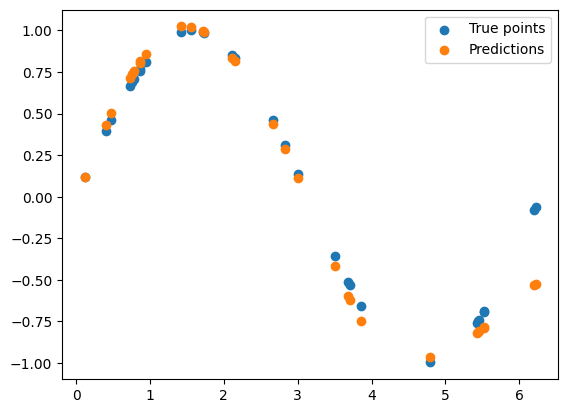

Avg loss: 0.016668 

Epoch: 140


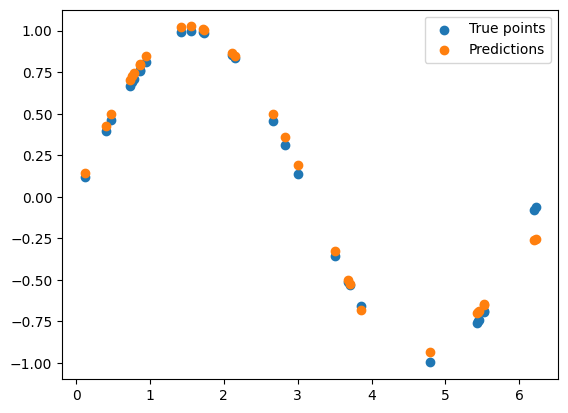

Avg loss: 0.003589 

Done!


In [13]:
jitter_std = 0.05

jitter_train_data = FunctionDataset(torch.sin, 30, jitter=jitter_std)
jitter_train_loader = DataLoader(jitter_train_data, shuffle=True)

loss_function = nn.MSELoss()
jitter_optimizer = torch.optim.SGD(jittered_model.parameters(), lr=learning_rate)

jitter_train_losses = []

for t in range(epochs):
    jitter_train_losses.append(train_loop(jitter_train_loader, jittered_model, loss_function, jitter_optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, jittered_model, loss_function)
print("Done!")

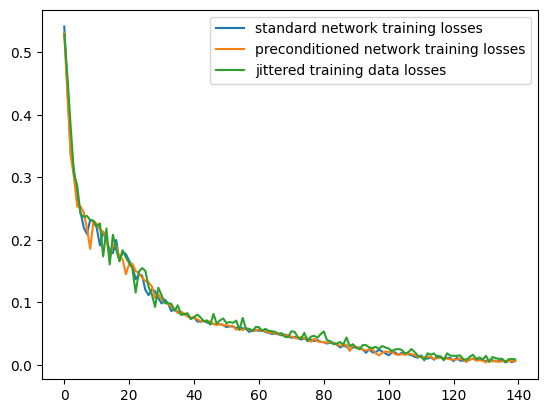

In [14]:
plt.plot(list(range(epochs)), standard_train_losses, label="standard network training losses")
plt.plot(list(range(epochs)), precond_training_losses, label="preconditioned network training losses")
plt.plot(list(range(epochs)), jitter_train_losses, label="jittered training data losses")
plt.legend()

## Using a copy of the same preconditioned network to learn a different function

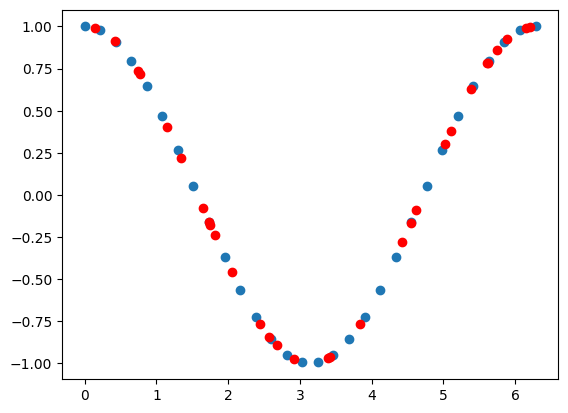

In [15]:
cos_train_data = FunctionDataset(torch.cos, 30)
cos_test_data = FunctionDataset(torch.cos, 30, rand_pts=True)
plt.scatter(cos_train_data.get_data().numpy(), cos_train_data.get_labels().numpy())
plt.scatter(cos_test_data.get_data().numpy(), cos_test_data.get_labels().numpy(), color='red')

cos_train_dataloader = DataLoader(cos_train_data, batch_size=1, shuffle=True)
cos_test_dataloader = DataLoader(cos_test_data, batch_size=1, shuffle=True)


In [16]:
learning_rate = 1e-2
epochs = 140

cos_model = copy.deepcopy(original_model)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(cos_model.parameters(), lr=learning_rate)

Epoch: 1


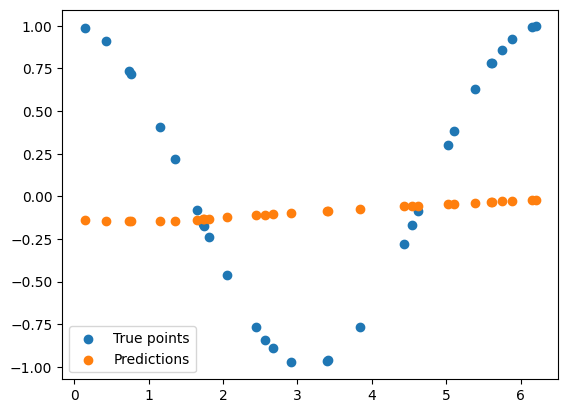

Avg loss: 0.491782 

Epoch: 2


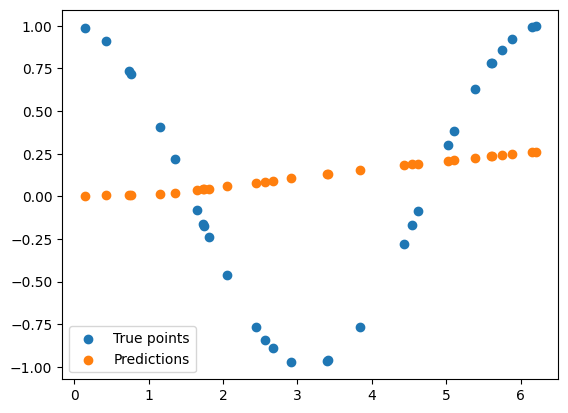

Avg loss: 0.452078 

Epoch: 3


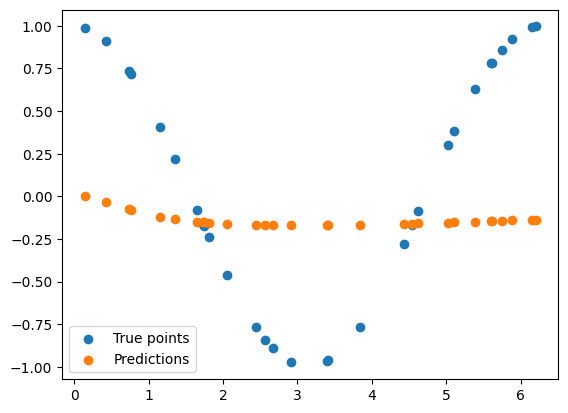

Avg loss: 0.493185 

Epoch: 4


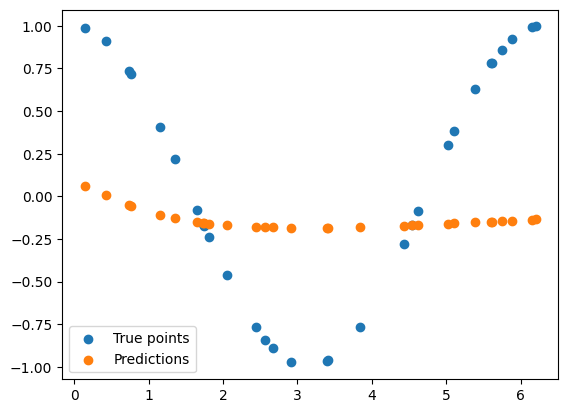

Avg loss: 0.480712 

Epoch: 5


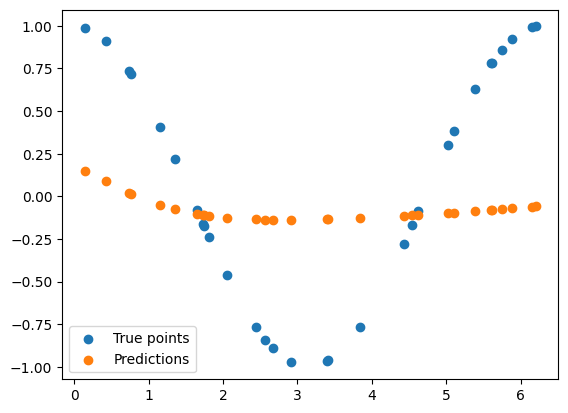

Avg loss: 0.441859 

Epoch: 6


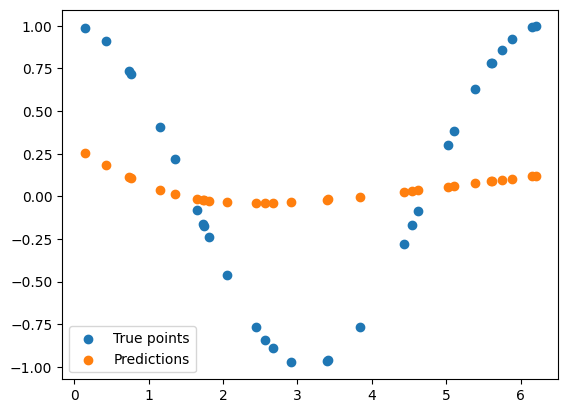

Avg loss: 0.394123 

Epoch: 7


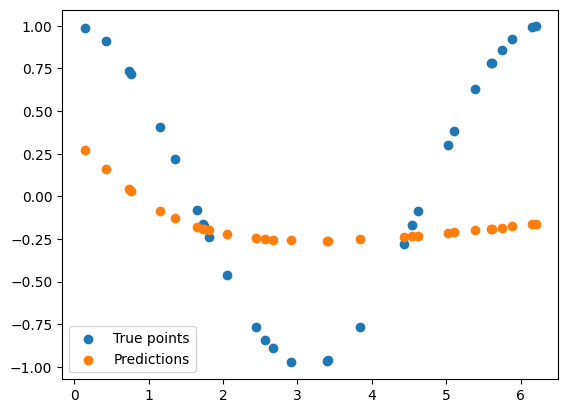

Avg loss: 0.448066 

Epoch: 8


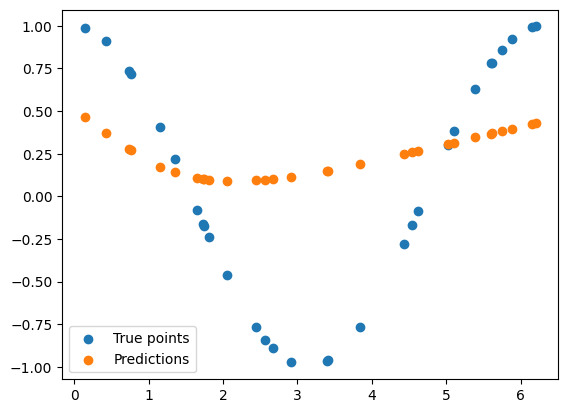

Avg loss: 0.366108 

Epoch: 9


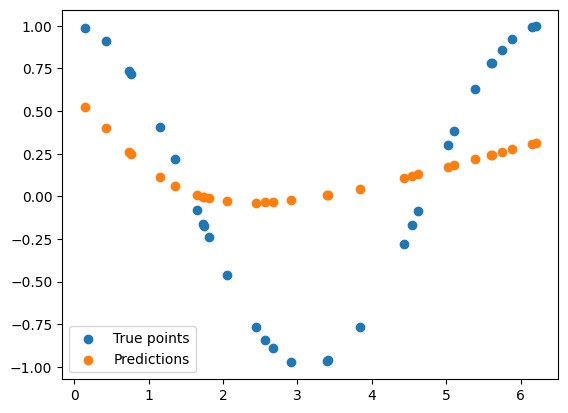

Avg loss: 0.316734 

Epoch: 10


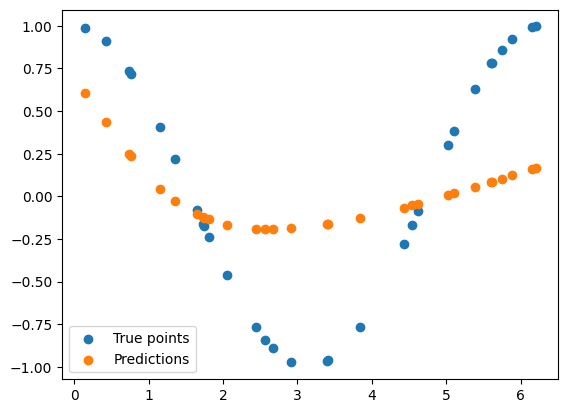

Avg loss: 0.295133 

Epoch: 11


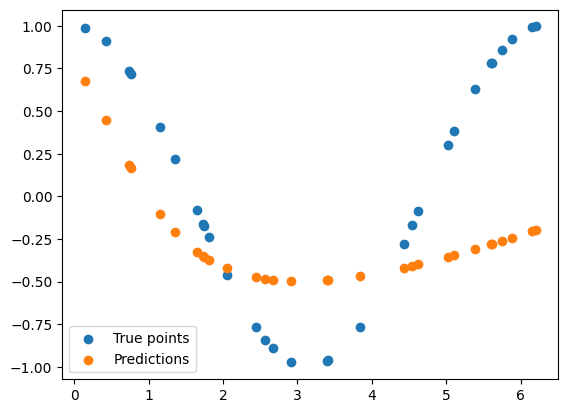

Avg loss: 0.412728 

Epoch: 12


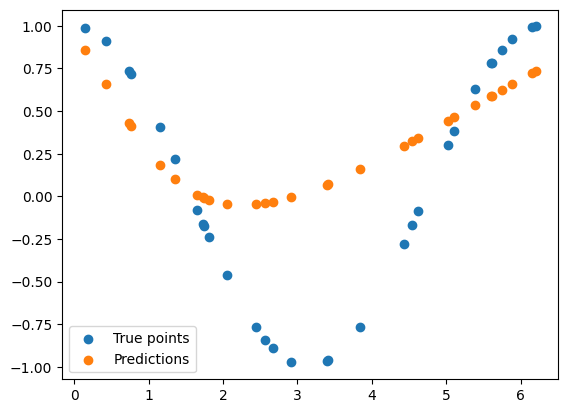

Avg loss: 0.252798 

Epoch: 13


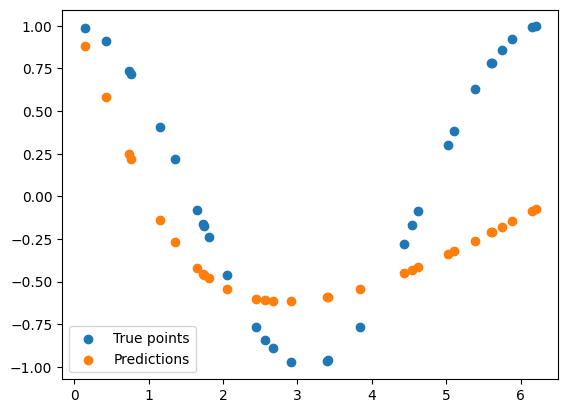

Avg loss: 0.350017 

Epoch: 14


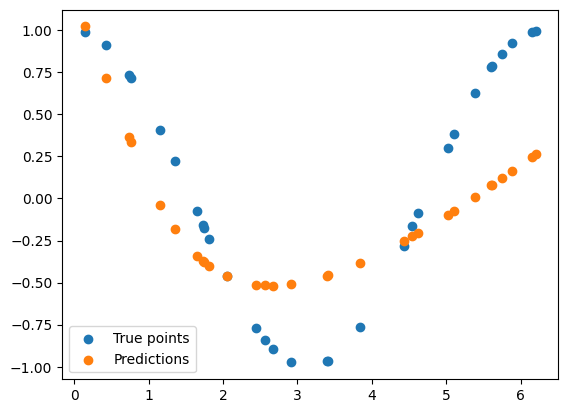

Avg loss: 0.200669 

Epoch: 15


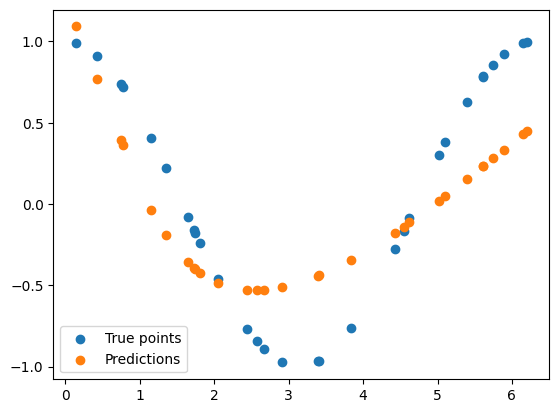

Avg loss: 0.146773 

Epoch: 28


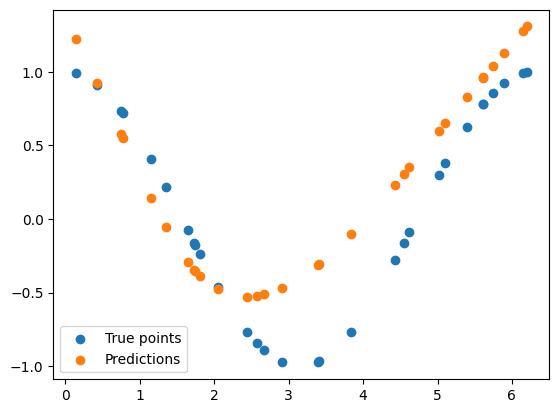

Avg loss: 0.114649 

Epoch: 56


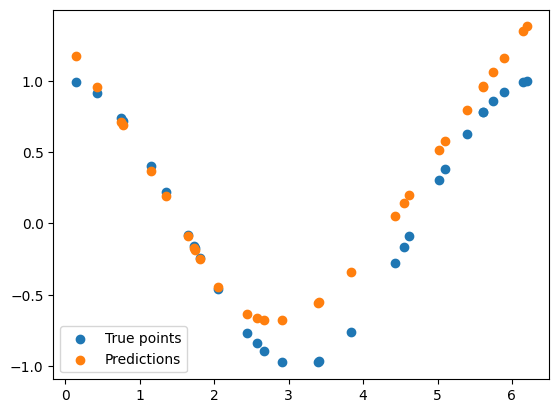

Avg loss: 0.052860 

Epoch: 84


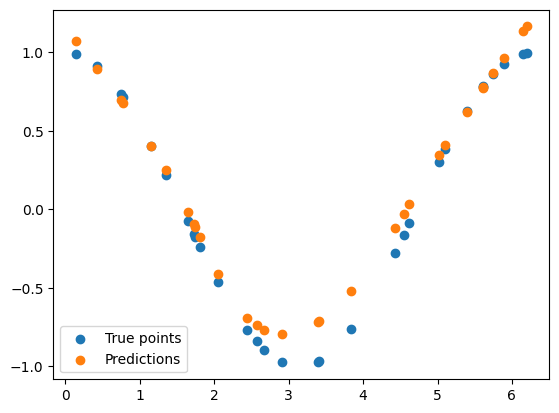

Avg loss: 0.013017 

Epoch: 112


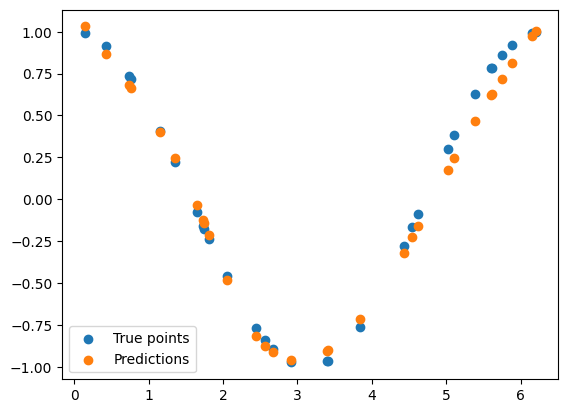

Avg loss: 0.006130 

Epoch: 140


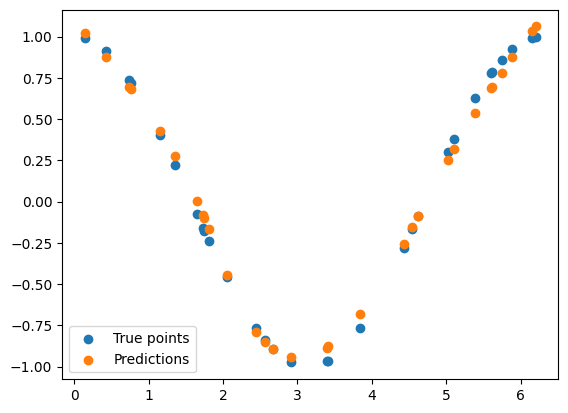

Avg loss: 0.003380 

Done!


In [17]:
standard_train_losses = []

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    standard_train_losses.append(train_loop(cos_train_dataloader, cos_model, loss_function, optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(cos_test_dataloader, cos_model, loss_function)
print("Done!")

Epoch: 1


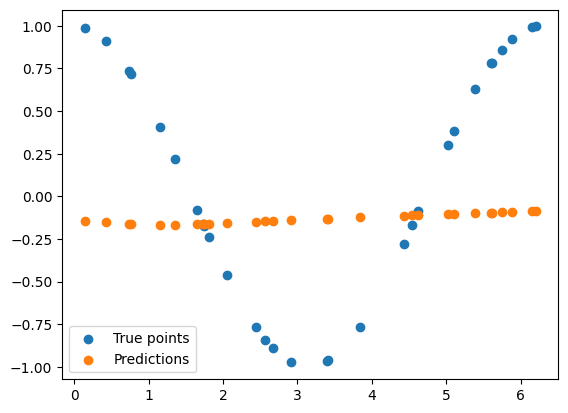

Avg loss: 0.509047 

Epoch: 2


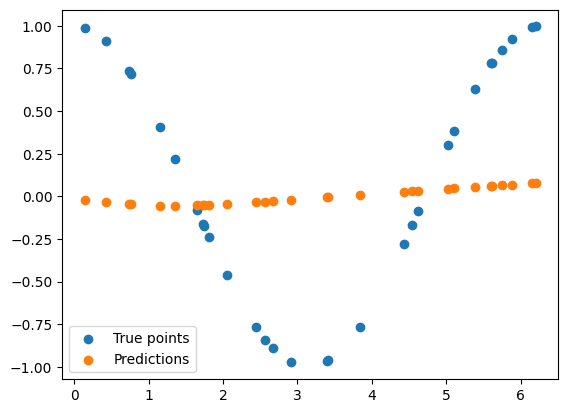

Avg loss: 0.455485 

Epoch: 3


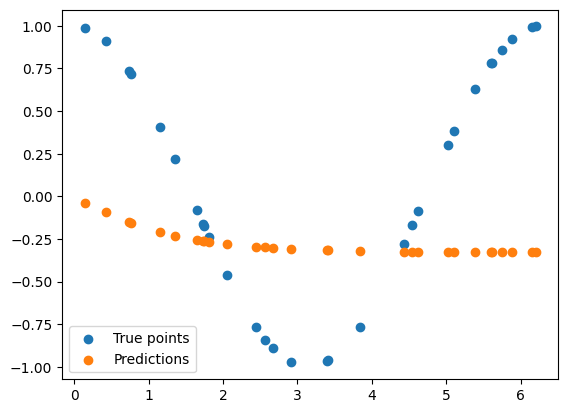

Avg loss: 0.582131 

Epoch: 4


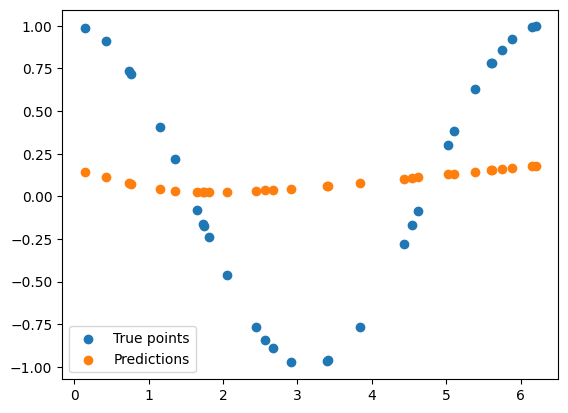

Avg loss: 0.422598 

Epoch: 5


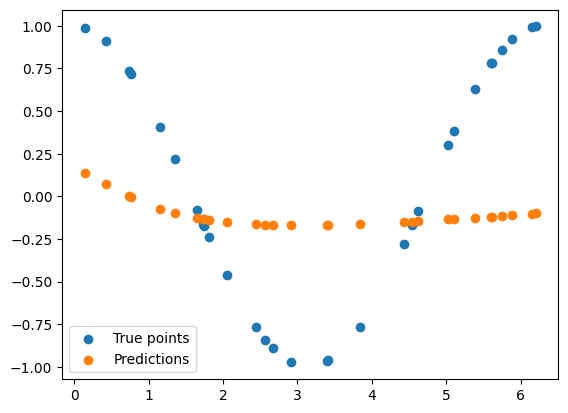

Avg loss: 0.454513 

Epoch: 6


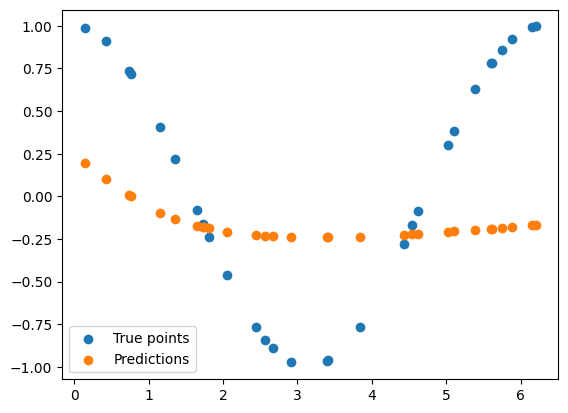

Avg loss: 0.465112 

Epoch: 7


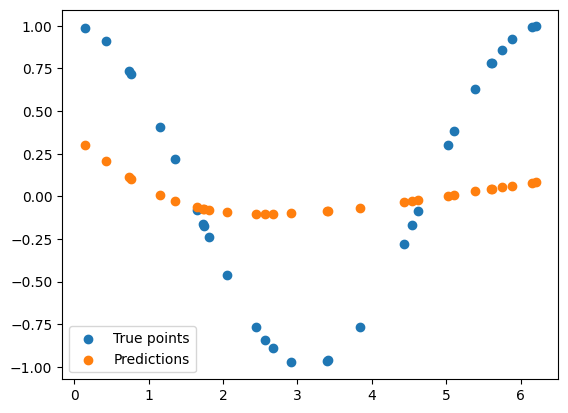

Avg loss: 0.379074 

Epoch: 8


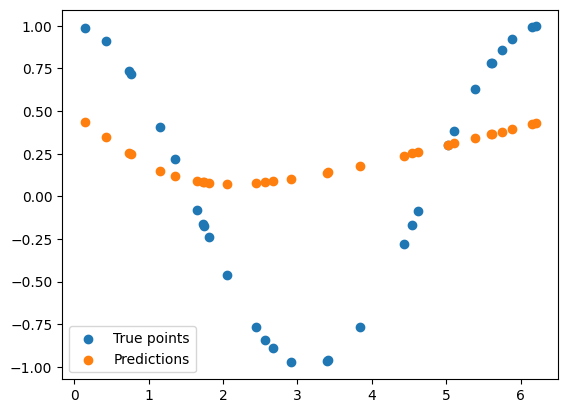

Avg loss: 0.362076 

Epoch: 9


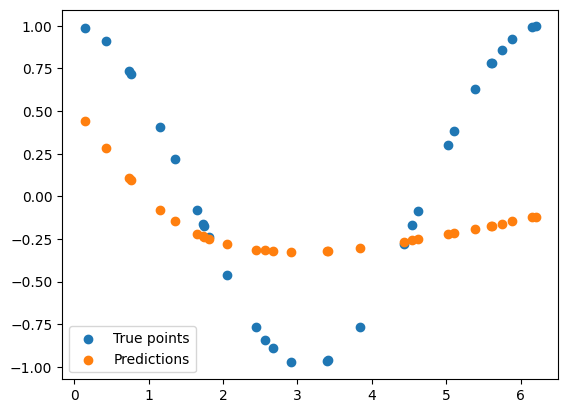

Avg loss: 0.400792 

Epoch: 10


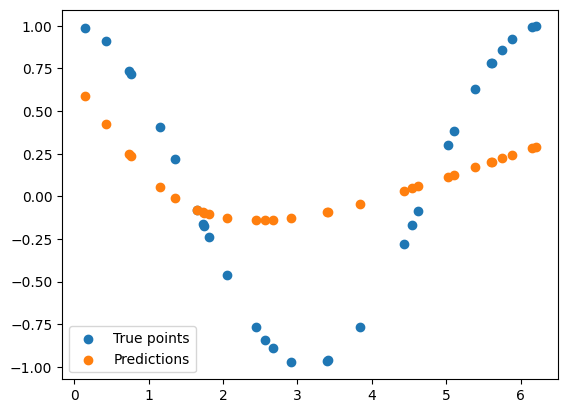

Avg loss: 0.280362 

Epoch: 11


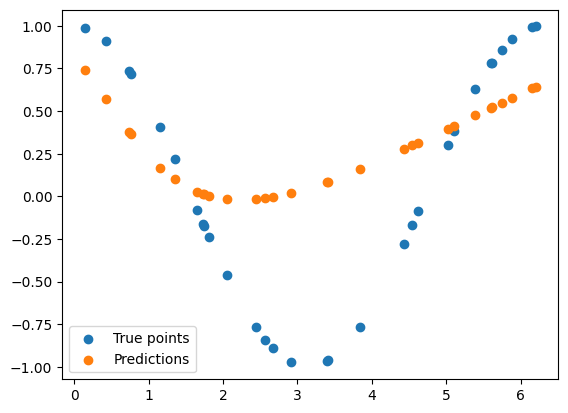

Avg loss: 0.274960 

Epoch: 12


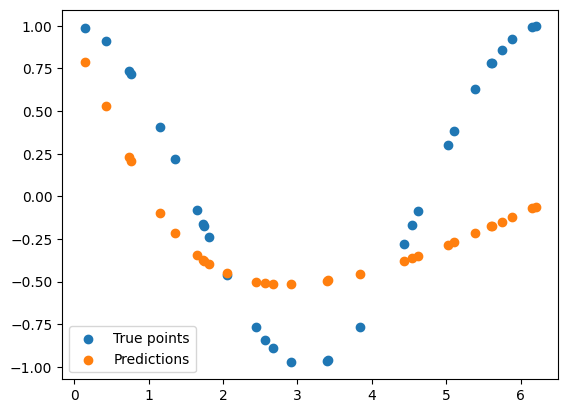

Avg loss: 0.339430 

Epoch: 13


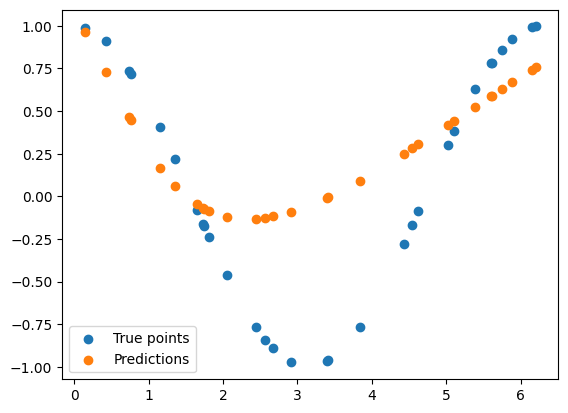

Avg loss: 0.208642 

Epoch: 14


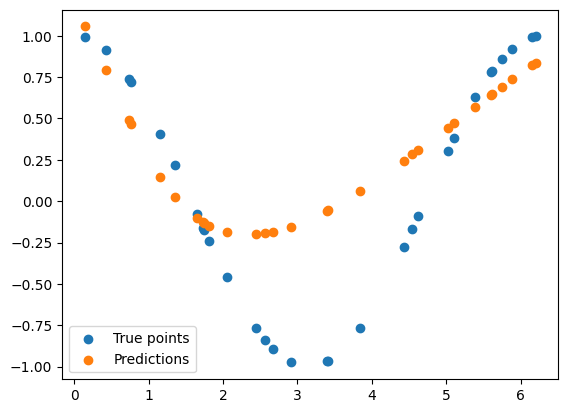

Avg loss: 0.180077 

Epoch: 15


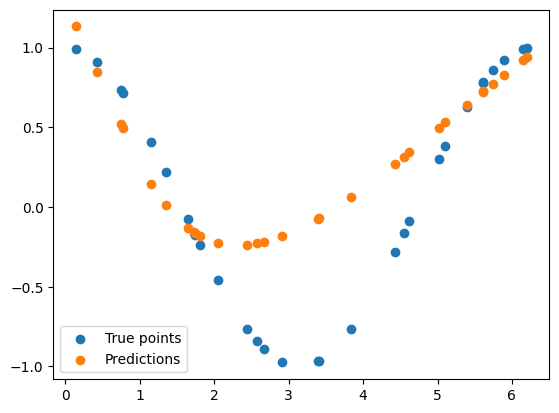

Avg loss: 0.171618 

Epoch: 28


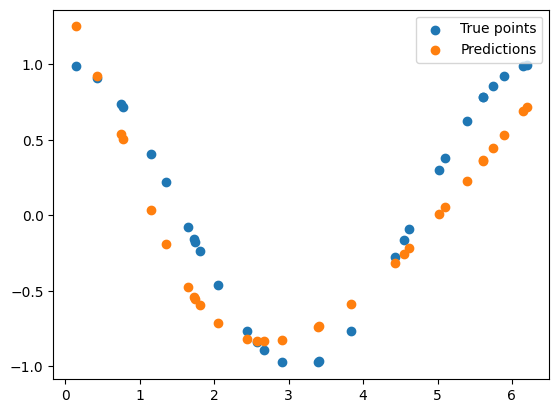

Avg loss: 0.083035 

Epoch: 56


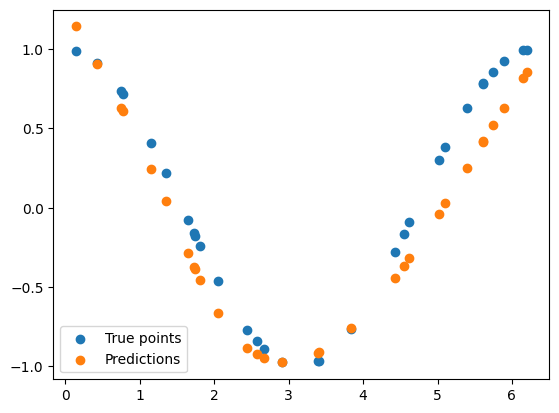

Avg loss: 0.045716 

Epoch: 84


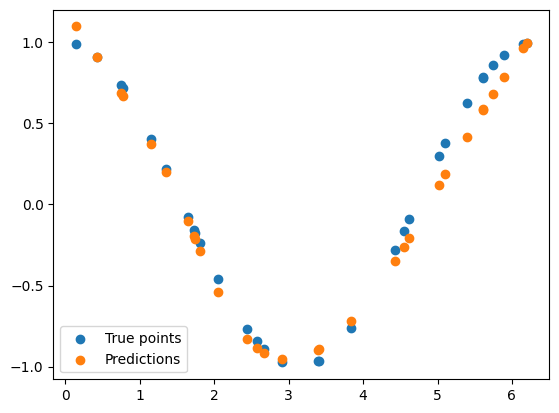

Avg loss: 0.010737 

Epoch: 112


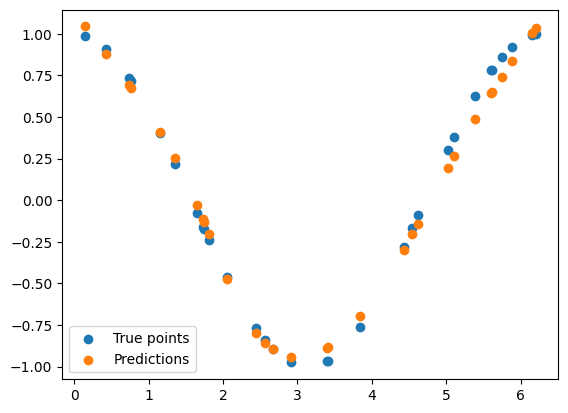

Avg loss: 0.004911 

Epoch: 140


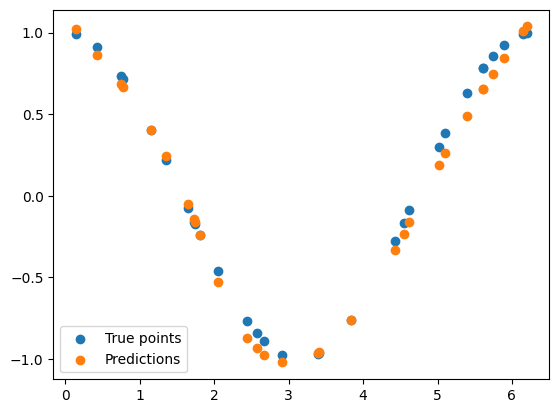

Avg loss: 0.005214 

Done!


In [18]:
training_optimizer = torch.optim.SGD(cos_precond_model.parameters(), lr=learning_rate)
precond_training_losses = []
for t in range(epochs):
    
    precond_training_losses.append(train_loop(cos_train_dataloader, cos_precond_model, loss_function, training_optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(cos_test_dataloader, cos_precond_model, loss_function)
print("Done!")

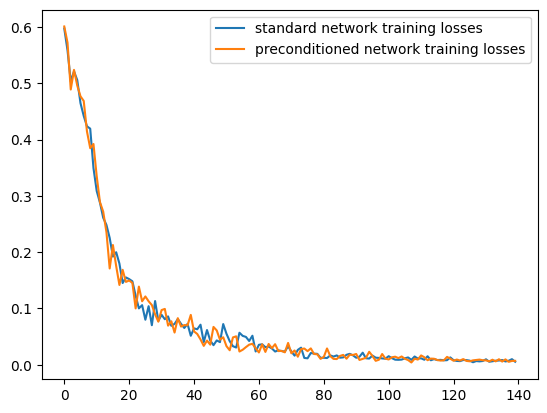

In [19]:
plt.plot(list(range(epochs)), standard_train_losses, label="standard network training losses")
plt.plot(list(range(epochs)), precond_training_losses, label="preconditioned network training losses")
plt.legend()